## Question 2: Cat Classifier

Start by checking internet connection and accessing the fastai library

In [ ]:
# NB: This code is heavily based on the fast.ai bird classifier example.
#    This code is only here to check that your internet is enabled.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Download cat images

Create a function that searches for images in the Duck Duck Go database

In [ ]:
# Install duckduckgo_search 
!pip install -Uqq duckduckgo_search

In [ ]:
# Import image search libraries
from duckduckgo_search import ddg_images
from fastcore.all import *

# Initialise search function will a maximum of 200 images
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Search for the relevant images to be classified.

In [ ]:
# Impport download libraries 
from fastdownload import download_url
from fastai.vision.all import *

# Define searches list and file path
searches = 'lion','tiger', 'panther cat', 'leopard', 'jaguar cat', 'cheetah', 'puma cat', 'ocelot', 'serval', 'lynx cat'
path = Path('cat_classifier')
# Import sleep function
from time import sleep

# Iterate over searches list
for o in searches:
    # Define the path for each image set
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    # Download images
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)
    sleep(1)

## Step 2: Train the model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

43

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

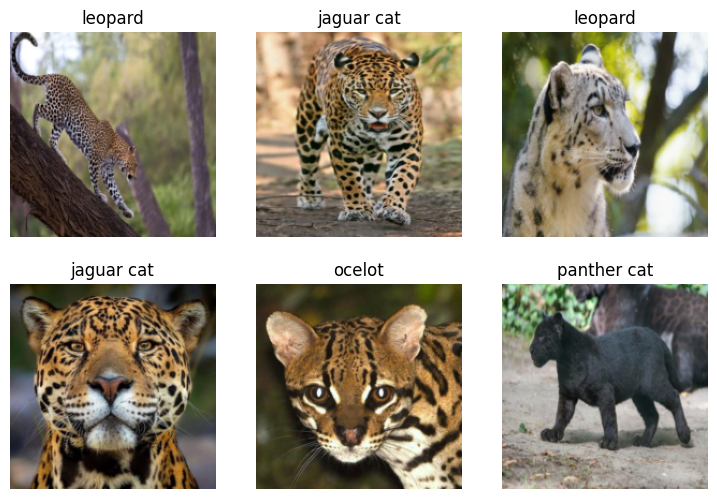

In [ ]:
# Create the data loaders and ensure the images are the same size (192x192) by 'squish'. Reserve 20% of the images for validation.
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

# Show an example batch of 6 images
dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
# Use resnet18 train as a reference and fine tune the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

The model only needs to be fine tuned three times for very accurate results.

# Step 3: Results

Create a confusion matrix of the results of the model

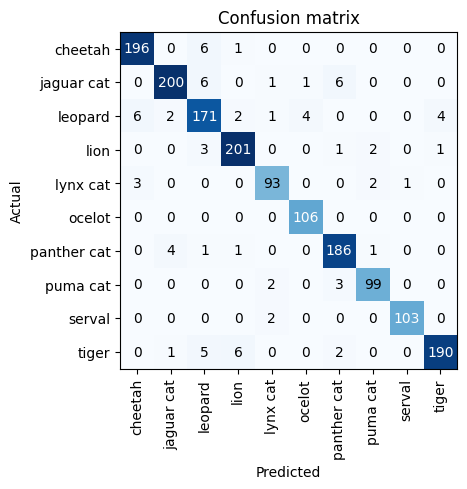

Bad pipe message: %s [b'B\x14\xa9?F\x9e\xda3\xb6F\xa1J\x7f;\x87$\xa3\x83 C\xb2\xa8\x8aF#\xbabe\x81\xf3']
Bad pipe message: %s [b'e\xe3w&x\xf7\x91\x91\xdb\xf6\xf3e\x9e\xf0\x03', b'l\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0']
Bad pipe message: %s [b"k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0"]
Bad pipe message: %s [b'\x91\xfb\xa0N\xfb0\xc9\x92\x08\xa5\xe2\x81\xc3\x0bc1\x9f"\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\x0e\xc0\x04\x00/\x00\x96\x00A\x00\x07\xc0\x11\xc0\x07\xc0\x16\x00\x18\xc0\x0c\xc0\x02\x00\x05\x00\x04\xc0\x12\xc0\x08\x00\x16\x00\x13\x00\x10\x00\

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion matrix above shows that the model is very accurate. The model struggled slightly discerning between cheetahs and jaguars as well as panthers and jaguars.

Display the top 5 losses including the prediction, actual, loss and probability

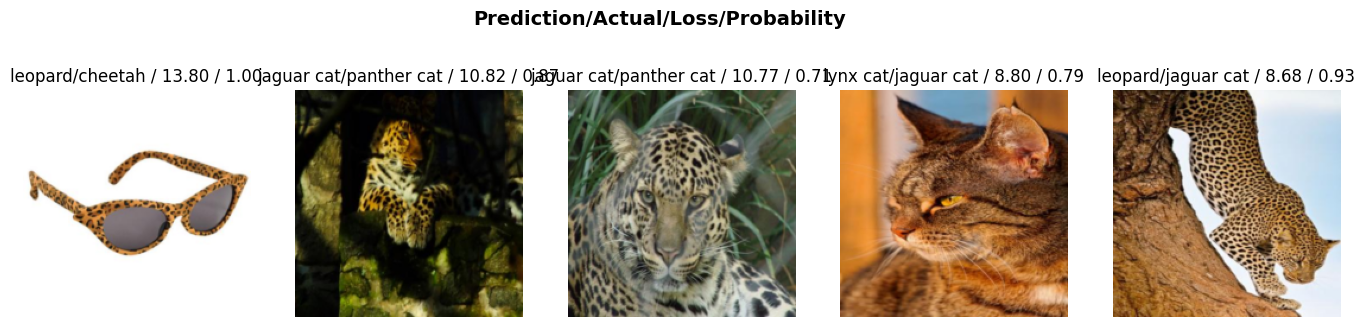

In [ ]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

As can be seen from the above, the top losses are either nonsense images, difficult images, or incorrectly sorted images. This is a good sign that the model works well.

Optional: Run a cleaner to fix the dataset

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

The multiclass loss function is the default categorical loss function used by the `vision_learner` function. Without directly setting it, fastai uses `F.cross_entropy` as its loss function. 

Cross-entropy has the mathematical function shown below:


$H(x)=-\sum\limits_{i}X_{i}\log(p(x_{i}))$

The one-hot encoded classifier results of the randomly selected image (*X*) is compared to the model's probability distribution of the predicted image (*p(x)*) by the use of the formula. The aim is to reduce the resultant loss calculated by the cross-entropy formula.